The BSD68 dataset was adapted from K. Zhang et al (TIP, 2017) and is composed of natural
images. The noise was artificially added, allowing for quantitative comparisons with the
ground truth, one of the benchmark used in many denoising publications. Here, we check 
the performances of Noise2Void.

In [1]:
# Imports necessary to execute the code
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import tifffile
from careamics import CAREamist
from careamics.config import create_hdn_configuration
from careamics.utils.metrics import scale_invariant_psnr
from careamics_portfolio import PortfolioManager
from PIL import Image

/localscratch/mamba/envs/cmcs/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Import the dataset

The dataset can be directly downloaded using the `careamics-portfolio` package, which
uses `pooch` to download the data.

In [2]:
# instantiate data portfolio manage
portfolio = PortfolioManager()

# and download the data
root_path = Path("./data")
files = portfolio.denoising.N2V_BSD68.download(root_path)

# create paths for the data
data_path = Path(root_path / "denoising-N2V_BSD68.unzip/BSD68_reproducibility_data")
train_path = data_path / "train"
val_path = data_path / "val"
test_path = data_path / "test" / "images"
gt_path = data_path / "test" / "gt"

## Visualize data

Text(0.5, 1.0, 'Validation Image')

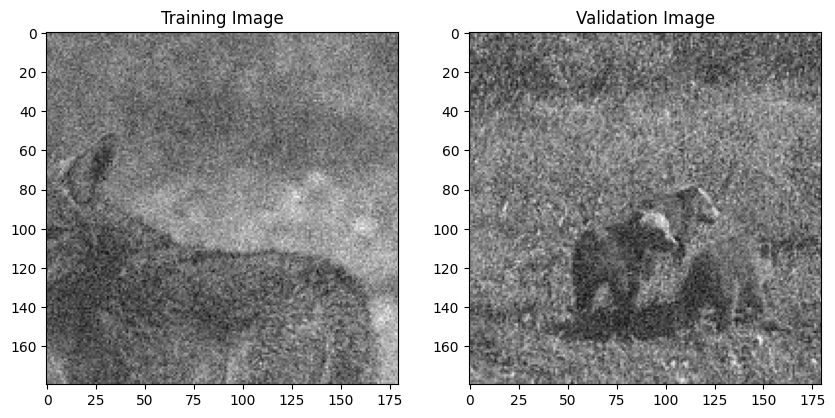

In [3]:
# load training and validation image and show them side by side
single_train_image = tifffile.imread(next(iter(train_path.rglob("*.tiff"))))[0]
single_val_image = tifffile.imread(next(iter(val_path.rglob("*.tiff"))))[0]

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(single_train_image, cmap="gray")
ax[0].set_title("Training Image")
ax[1].imshow(single_val_image, cmap="gray")
ax[1].set_title("Validation Image")

## Train with CAREamics

The easiest way to use CAREamics is to create a configuration and a `CAREamist`. 

### Create configuration

The configuration can be built from scratch, giving the user full control over the various
parameters available in CAREamics. However, a straightforward way to create a configuration
for a particular algorithm is to use one of the convenience functions.

In [4]:
config = create_hdn_configuration(
    experiment_name="bsd68_hdn",
    data_type="tiff",
    axes="SYX",
    z_dims=[32] * 6,
    patch_size=(128, 128),
    batch_size=64,
    num_epochs=100,
    predict_logvar=None,
    logger="wandb"
)

print(config)

{'algorithm_config': {'algorithm': 'hdn',
                      'gaussian_likelihood': {},
                      'loss': {'denoisplit_weight': 1.0,
                               'kl_params': {'aggregation': 'mean',
                                             'annealing': False,
                                             'annealtime': 10,
                                             'current_epoch': 0,
                                             'free_bits_coeff': 0.0,
                                             'loss_type': 'kl',
                                             'rescaling': 'latent_dim',
                                             'start': -1},
                               'kl_weight': 1.0,
                               'loss_type': 'hdn',
                               'musplit_weight': 0.0,
                               'non_stochastic': False,
                               'reconstruction_weight': 1.0},
                      'lr_scheduler': {'name': 'ReduceL

In [7]:
config.algorithm_config.loss.reconstruction_weight = 1-0.15
config.algorithm_config.loss.kl_weight = 0.15

In [11]:
config.algorithm_config.lr_scheduler.parameters = {"factor": 0.5, "patience": 10}
config.algorithm_config.optimizer = {"name": "Adamax", "parameters": {"lr": 0.0003}}

In [12]:
config.algorithm_config.optimizer


OptimizerModel(name='Adamax', parameters={'lr': 0.0003})

In [13]:
config.algorithm_config.lr_scheduler

LrSchedulerModel(name='ReduceLROnPlateau', parameters={'factor': 0.5, 'patience': 10})

### Train

A `CAREamist` can be created using a configuration alone, and then be trained by using
the data already loaded in memory.

In [14]:
# instantiate a CAREamist
careamist = CAREamist(source=config)

# train
careamist.train(
    train_source=train_path,
    val_source=val_path,
)

No working directory provided. Using current working directory: /home/igor.zubarev/projects/careamics-examples/applications/hdn/2D.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A40-16Q') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


[GaussianLikelihood] PredLVar:None LowBLVar:None


wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: sharky (juglab). Use `wandb login --relogin` to force relogin
wandb: WARNING Path /home/igor.zubarev/projects/careamics-examples/applications/hdn/2D/wandb_logs/wandb/ wasn't writable, using system temp directory.


Extracted 12672 patches from input array.
Computed dataset mean: [110.67197], std: [63.35263]
Extracted 16 patches from input array.
/localscratch/mamba/envs/cmcs/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:653: Checkpoint directory /home/igor.zubarev/projects/careamics-examples/applications/hdn/2D/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type               | Params
-----------------------------------------------------------
0 | model               | LVAE               | 887 K 
1 | gaussian_likelihood | GaussianLikelihood | 0     
-----------------------------------------------------------
887 K     Trainable params
0         Non-trainable params
887 K     Total params
3.549     Total estimated model params size (MB)


Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]

/localscratch/mamba/envs/cmcs/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


/localscratch/mamba/envs/cmcs/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


Epoch 99: 100%|██████████| 198/198 [00:40<00:00,  4.84it/s, val_loss=0.0969, val_reconstruction_loss=0.075, val_kl_loss=0.0219, val_psnr=24.2] 

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 198/198 [00:41<00:00,  4.80it/s, val_loss=0.0969, val_reconstruction_loss=0.075, val_kl_loss=0.0219, val_psnr=24.2]


## Predict with CAREamics

Prediction is done with the same `CAREamist` used for training.

In [15]:
careamist.model.model.reset_for_inference(tile_size=(256, 256))

In [16]:
prediction = careamist.predict(
    source=test_path,
    axes="YX",
    tile_size=(256, 256),
    tile_overlap=(64, 64),
    mmse_count = 50,
    batch_size=8,
)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/localscratch/mamba/envs/cmcs/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


Predicting DataLoader 0: |          | 51/? [01:42<00:00,  0.50it/s]


### Visualize the prediction

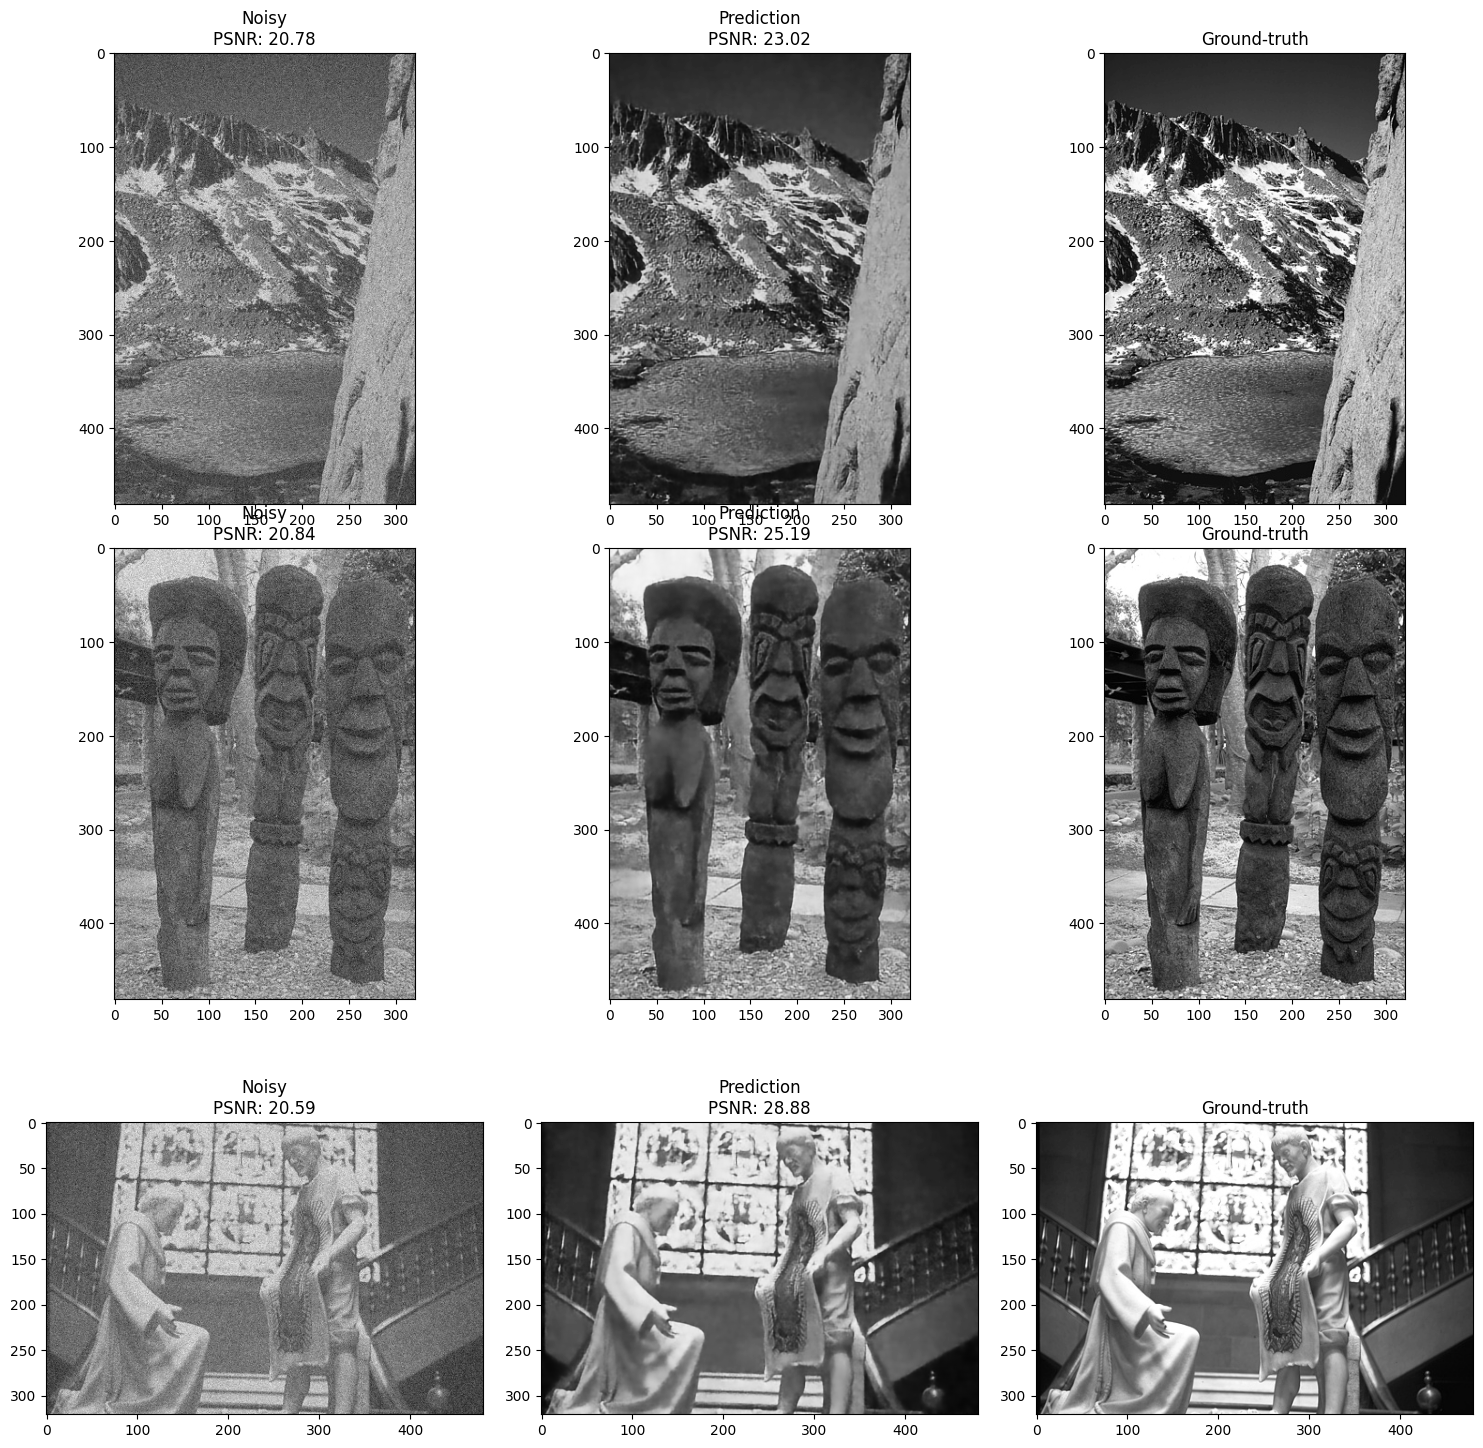

In [17]:
# Show two images
noises = [tifffile.imread(f) for f in sorted(test_path.glob("*.tiff"))]
gts = [tifffile.imread(f) for f in sorted(gt_path.glob("*.tiff"))]

# images to show
images = np.random.choice(range(len(noises)), 3)

fig, ax = plt.subplots(3, 3, figsize=(15, 15))
fig.tight_layout()

for i in range(3):
    pred_image = prediction[images[i]].squeeze()
    psnr_noisy = scale_invariant_psnr(gts[images[i]], noises[images[i]])
    psnr_result = scale_invariant_psnr(gts[images[i]], pred_image)

    ax[i, 0].imshow(noises[images[i]], cmap="gray")
    ax[i, 0].title.set_text(f"Noisy\nPSNR: {psnr_noisy:.2f}")

    ax[i, 1].imshow(pred_image, cmap="gray")
    ax[i, 1].title.set_text(f"Prediction\nPSNR: {psnr_result:.2f}")

    ax[i, 2].imshow(gts[images[i]], cmap="gray")
    ax[i, 2].title.set_text("Ground-truth")

### Compute metrics

In [18]:
psnrs = np.zeros((len(prediction), 1))

for i, (pred, gt) in enumerate(zip(prediction, gts)):
    psnrs[i] = scale_invariant_psnr(gt, pred.squeeze())

print(f"PSNR: {psnrs.mean():.2f} +/- {psnrs.std():.2f}")
print("Reported PSNR: 27.71")

PSNR: 27.55 +/- 2.28
Reported PSNR: 27.71


## Create cover

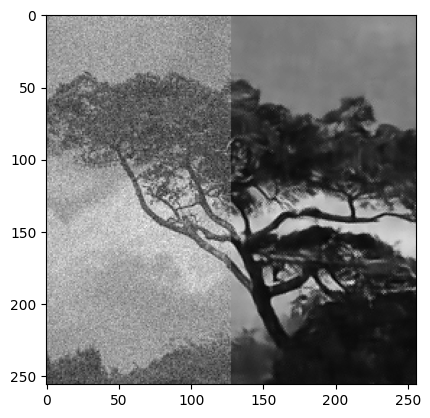

In [9]:
# create a cover image
im_idx = 3
cv_image_noisy = noises[im_idx]
cv_image_pred = prediction[im_idx].squeeze()

# create image
cover = np.zeros((256, 256))
(height, width) = cv_image_noisy.shape
assert height > 256
assert width > 256

# normalize train and prediction
norm_noise = (cv_image_noisy - cv_image_noisy.min()) / (
    cv_image_noisy.max() - cv_image_noisy.min()
)
norm_pred = (cv_image_pred - cv_image_pred.min()) / (
    cv_image_pred.max() - cv_image_pred.min()
)

# fill in halves
cover[:, : 256 // 2] = norm_noise[
    height // 2 - 256 // 2 : height // 2 + 256 // 2, width // 2 - 256 // 2 : width // 2
]
cover[:, 256 // 2 :] = norm_pred[
    height // 2 - 256 // 2 : height // 2 + 256 // 2, width // 2 : width // 2 + 256 // 2
]

# plot the single image
plt.imshow(cover, cmap="gray")

# save the image
im = Image.fromarray(cover * 255)
im = im.convert("L")
im.save("BSD68_Noise2Void.jpeg")

In [11]:
# Export the model
careamist.export_to_bmz(
    path_to_archive="bsd68_n2v_model.zip",
    friendly_model_name="BSD68_N2V",
    input_array=noises[im_idx][np.newaxis, ..., :256, :256],
    authors=[{"name": "CAREamics authors", "affiliation": "Human Technopole"}],
)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/localscratch/miniforge3/envs/careamics/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

computing SHA256 of inputs.npy (result: 4e99b89c03663aafbcdd7b1a92d0db4e3421c05ea63f68163e7a5d61775095c8): 100%|██████████| 3/3 [00:00<00:00, 1180.05it/s]
computing SHA256 of outputs.npy (result: a79cf7edbaee8320b4c19d755cc2a4d7945681e8e6522f45a9c056c54b6a47ef): 100%|██████████| 3/3 [00:00<00:00, 1695.35it/s]
computing SHA256 of environment.yml (result: d743faa28b30f054d6caa699271006e27d3cda48e07c02cf092b4e0732830574): 100%|██████████| 1/1 [00:00<00:00, 867.31it/s] 
computing SHA256 of weights.pth (result: ca2b5bafccb5d5d4f35b557d17c973a2a0cce8c51515d4867092970e278ae849): 100%|██████████| 16/16 [00:00<00:00, 5814.32it/s]
computing SHA256 of config.yml (result: f57e31e3392743a721fd489d29628c89a23687563470a5bf46fb81825ee80b9e): 100%|██████████| 1/1 [00:00<00:00, 912.60it/s] 
2024-09-19 16:15:00.647 | Level 30 | bioimageio.spec._internal.field_warning:issue_warning:149 - documentation: No '# Validation' (sub)section found in /home/melisande.croft/.careamics/README.md.
2024-09-19 16:15:00.